In [11]:
import torch
from torch import optim, nn
import torchvision
from torch.utils.data import DataLoader
from Preprocess import Anime
from torchvision.models import resnet18,ResNet18_Weights
from utils import Flatten
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange


In [12]:
batchze = 32
lr = 1e-3
epochs = 100
device = torch.device('cuda')
torch.manual_seed(1234)

# load data 
train_db = Anime('..\\Images', 224, 'train')
val_db = Anime('..\\Images', 224, 'val')
test_db = Anime('..\\Images', 224, 'test')


train_loader = DataLoader(train_db,batch_size= batchze, shuffle= True)
val_loader = DataLoader(val_db,batch_size= batchze)
test_loader = DataLoader(test_db,batch_size= batchze)

In [13]:
#evaluate function
def evaluate(model, loader):
    correct = 0
    total = len(loader.dataset)
    for x , y in loader:
        x, y  = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim = 1)
        correct += torch.eq(pred, y).sum().float().item()
    return correct / total

In [14]:

# model = ResNet18(4).to(device)
trained_model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = nn.Sequential(*list(trained_model.children())[:-1],# [b,512,1,1]
                        Flatten(),
                        nn.Linear(512,50)
                        ).to(device)
optimizer = optim.Adam(model.parameters(),lr = lr)
criteon = nn.CrossEntropyLoss()

best_acc, best_epoch = 0, 0
global_step = 0
loss_data = []
val_acc_data = []
for epoch in trange(epochs, unit="epochs"):
    for step, (x,y) in enumerate(train_loader):
        # x: [b,3,512,512] y:[b]
        x, y  = x.to(device), y.to(device)

        logits = model(x)
        loss = criteon(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_data.append(loss.item())
        global_step += 1
    if epoch % 1 == 0:
        val_acc = evaluate(model, val_loader)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(),'best_baseline.mdl')
        val_acc_data.append(val_acc)
print("best acc:", best_acc, "best epoch:", best_epoch)
model.load_state_dict(torch.load("best_baseline.mdl")) # load best state

print("loaded from checkpoint! ")

test_acc = evaluate(model, test_loader)
print("test acc:", test_acc)


100%|██████████| 100/100 [25:20<00:00, 15.20s/epochs]


best acc: 0.9507829977628636 best epoch: 15
loaded from checkpoint! 
test acc: 0.9507829977628636


Text(0.5, 1.0, 'val_acc')

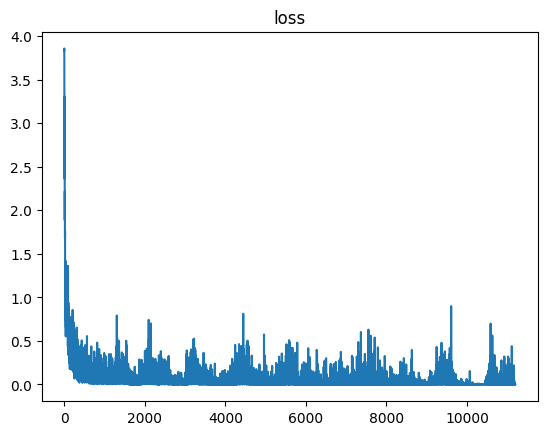

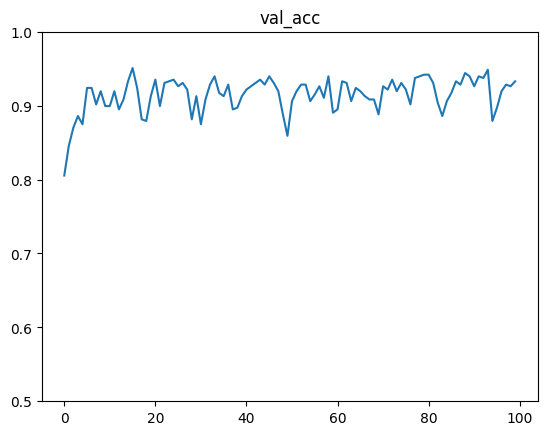

In [17]:
x = np.arange(0, global_step)
x_2 = np.arange(0,epoch + 1)
fig, ax = plt.subplots()
ax.plot(x, loss_data)
ax.set_title('loss')
fig2, ax2 = plt.subplots()
ax2.plot(x_2,val_acc_data)
plt.ylim([0.5, 1])
ax2.set_title('val_acc')

In [16]:
p = sum(map(lambda p:p.numel(), model.parameters()))
print('parameters size:', p)

parameters size: 11202162
